In [235]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [242]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
# torch.cuda.set_device(1)
import skimage.io as io
import tqdm
import os
from fastai.vision.learner import cnn_config
from fastai.callbacks import LossMetrics,SaveModelCallback
from Unet import UnetResnet34
from fastai.callbacks.hooks import *

In [255]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)
import cv2
import torchvision.transforms as transforms
import PIL.Image as IMG
scaler = transforms.Resize((256, 256))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def visualize_bbox(img, bbox,color=BOX_COLOR, thickness=2):
#     x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(float(bbox[0])), int(float(bbox[2]))+int(float(bbox[0])), int(float(bbox[1])), int(float(bbox[3]))+int(float(bbox[1]))
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
#     class_name = classname
#     ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
#     cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
#     cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img

def visualize(path,bbox):
    img=io.imread(path)
    img = visualize_bbox(img, bbox)
    return img

In [251]:
def Gramdata(m,inputs,c):
    layer=m[0]
    with hook_output(layer) as hook_a:
        with hook_output(layer, grad= True) as hook_g:
            preds = m(inputs)
            preds[0,c].backward()
    acts = hook_a.stored[0].cpu()
#     print(acts2.shape)
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    mult = mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult

In [252]:
def normalize_atten_maps(atten_maps):
    atten_shape = atten_maps.size()

    #--------------------------
    batch_mins, _ = torch.min(atten_maps.view(atten_shape[0:-2] + (-1,)), dim=-1, keepdim=True)
    batch_maxs, _ = torch.max(atten_maps.view(atten_shape[0:-2] + (-1,)), dim=-1, keepdim=True)
    atten_normed = torch.div(atten_maps.view(atten_shape[0:-2] + (-1,))-batch_mins,
                             batch_maxs - batch_mins)
    atten_normed = atten_normed.view(atten_shape)
    return atten_normed
def get_localization_maps(inputs):
    map1 = normalize_atten_maps(inputs)
    # map_erase = self.normalize_atten_maps(self.map_erase)
    # return torch.max(map1, map_erase)
    return map1

In [253]:
def Acol(model,inputs):
    logits=model(inputs)
    last_featmaps = get_localization_maps(logits[3])
    return last_featmaps[0][0].detach().cpu().numpy()

In [174]:
model=torch.load('./weight/birdresnet34.pth')
model=model.float().cuda().eval()


In [189]:
model2=torch.load('./weight/Acolbird.pth')
model2=model2.float().cuda().eval()

In [6]:
from tensorwatch import image_utils, imagenet_utils, pytorch_utils

In [16]:
path=Path('./CUB_200_2011/images/')

In [133]:
datalist=pd.read_csv('./CUB_200_2011/images.txt',header=None)
boxist=pd.read_csv('./CUB_200_2011/bounding_boxes.txt',header=None)

In [256]:
idx=np.random.randint(len(datalist))

In [257]:
classname=datalist.iloc[idx,0].split(' ')[1].split('/')[0]
image='./CUB_200_2011/images/'+datalist.iloc[idx,0].split(' ')[1]
bbox=lockist.iloc[idx,0].split(' ')[1:]
Class=classname.split('.')[1]
Classnum=int(classname.split('.')[0])-1

In [258]:
raw=visualize(image,bbox)


In [259]:
xb=normalize(to_tensor(scaler(IMG.open(image)))).unsqueeze(0).cuda()
grad=Gramdata(model,xb,Classnum).cpu().numpy()

In [260]:
acol=Acol(model2,xb)

(0.0, 411.0, 500.0, 0.0)

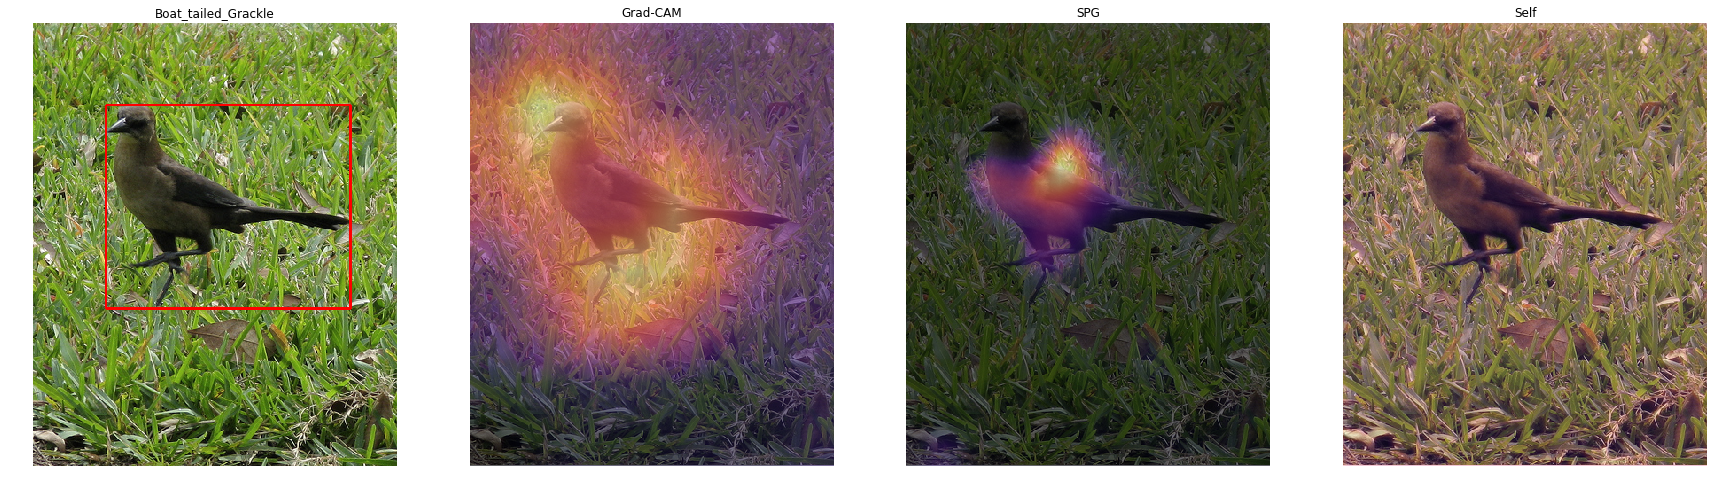

In [314]:
plt.figure(figsize=(30,10))
plt.subplot(141)
plt.imshow(raw)
plt.title(Class)
plt.axis('off')
plt.subplot(142)
plt.title('Grad-CAM')
plt.imshow(io.imread(image))
plt.imshow(grad, alpha=0.6, extent=(0,raw.shape[1],raw.shape[0],0),
              interpolation='bilinear', cmap='magma')
plt.axis('off')
plt.subplot(143)
plt.title('SPG')
plt.imshow(io.imread(image))
plt.imshow(acol, alpha=0.6, extent=(0,raw.shape[1],raw.shape[0],0),
              interpolation='bilinear', cmap='magma')
plt.axis('off')
plt.subplot(144)
plt.title('Self')
plt.imshow(io.imread(image))
plt.imshow((uu[1]-uu[0]), alpha=0.3, extent=(0,raw.shape[1],raw.shape[0],0),
              interpolation='bilinear', cmap='magma')
plt.axis('off')

In [243]:
model3=torch.load('./weight/bird2laterunet.pth')

In [244]:
model3=model3.float().cuda().eval()

In [299]:
def Gramdata(m,inputs):
    layer=m.final
    with hook_output(layer) as hook_a:
        preds = m(inputs)
    acts = hook_a.stored[0].cpu()
    return acts.numpy()

In [300]:
uu=Gramdata(model3,xb)

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


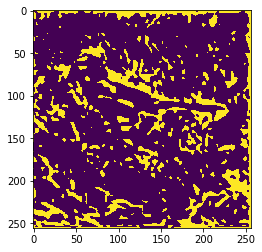

In [310]:
plt.imshow((uu[1]-uu[0])>-3.8)

In [308]:
np.percentile(uu[1]-uu[0],80)

-3.8133883476257324